   # TP53: Effects of Mutation on Interacting Proteins

<b>Standard imports for playing with and plotting data frames.</b>

In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns

<b>Import CPTAC data</b>

In [2]:
import CPTAC

Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [3]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

In [4]:
gene = 'TP53'
protList = ['TGFB1', 'AXIN1', 'EP300', 'HRMT1L2', 'CARM1', 'TAF1', 'ING4', 'CABLES1', 
            'TP73', 'HIPK1', 'HIPK2', 'TP53INP1', 'TP53BP', 'WWOX', 'HCV', 'USP7', 'SYVN1', 'HSP90AB1',
           'CHD8', 'ARMC10', 'BANP', 'CDKN2AIP', 'NUAK1', 'STK11', 'LKB1', 'UHRF2', 'E4F1', 'YWHAZ',
           'MAML1', 'MKRN1', 'PML', 'MDM2', 'FBXO42', 'ATM', 'PP2R2A', 'AURKA', 'DAXX', 'BRD7', 'TRIM24',
           'L3MBTL1', 'GRK5', 'CAK', 'PTK2B', 'PYK2', 'MDM2', 'PRKCG', 'PPIF', 'KAT6A', 'UBC9', 'ZNF385B',
           'ZNF385A', 'ANKRD2', 'RFFL', 'RNF34', 'MTA1', 'COP1', 'CCAR2', 'MORC3', 'POU4F2', 'AFG1L', 'UBD',
           'TAF6', 'HPV', 'UL123', 'E1B-55K', 'BAX', 'FAS', 'BCL2', 'CREBBP', 'CDK2', 'MDM2', 'CDKN2A', 'ATM',
            'CCNB1', 'TERT', 'IGF1R', 'ALB', 'MMP1']

## t-test for effects of missense mutations

In [5]:
tested = [];
p_vals = [];
for protein in protList: 
    if protein in proteomics.columns:
        tested.append(protein)
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross.loc[cross['Patient_Type'] == 'Tumor'][["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] == "Missense_Mutation"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        p_vals.append(ttest[1])

In [6]:
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_vals)[0]
pvals = statsmodels.stats.multitest.fdrcorrection(p_vals)[1]
missense_significant_proteins = np.array(tested)[np.array(areSignificant)]
significant_pvals = np.array(pvals)[np.array(areSignificant)]

### List of significantly affected proteins and their respective p-values (FDR adjusted)

In [7]:
print(missense_significant_proteins)
print(significant_pvals)

['CABLES1' 'HSP90AB1' 'CHD8' 'CDKN2AIP' 'UHRF2' 'YWHAZ' 'AURKA' 'DAXX'
 'AFG1L' 'TAF6' 'FAS' 'CDKN2A']
[0.01198163 0.02933247 0.01198163 0.03426805 0.02920811 0.01198163
 0.01036627 0.01554115 0.03943006 0.03426805 0.00441439 0.02874655]


## t-test for effects of frame shift and nonsense mutations (truncating)

In [8]:
tested = [];
p_vals = [];
for protein in protList: 
    if protein in proteomics.columns:
        tested.append(protein)
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross.loc[cross['Patient_Type'] == 'Tumor'][["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[(cross["Mutation"] == "Frame_Shift_Del") | 
                            (cross["Mutation"] == "Frame_Shift_Ins") |
                            (cross["Mutation"] == 'Nonsense_Mutation')]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        p_vals.append(ttest[1])

In [9]:
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_vals)[0]
pvals = statsmodels.stats.multitest.fdrcorrection(p_vals)[1]
truncating_significant_proteins = np.array(tested)[np.array(areSignificant)]
significant_pvals = np.array(pvals)[np.array(areSignificant)]

In [10]:
print(truncating_significant_proteins)
print(significant_pvals)

['CABLES1' 'CHD8' 'FAS' 'CDK2' 'CDKN2A' 'CCNB1']
[0.0059016  0.00027794 0.0059016  0.0408439  0.00625023 0.00866919]


## List of proteins significant for either one

In [11]:
significant_proteins = np.unique(np.concatenate([missense_significant_proteins, truncating_significant_proteins]))
significant_proteins

array(['AFG1L', 'AURKA', 'CABLES1', 'CCNB1', 'CDK2', 'CDKN2A', 'CDKN2AIP',
       'CHD8', 'DAXX', 'FAS', 'HSP90AB1', 'TAF6', 'UHRF2', 'YWHAZ'],
      dtype='<U8')

## Plot all significant results (including p53 itself)

In [165]:
plotdf = CPTAC.compare_mutations(proteomics, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]

significant_proteins = ['CDKN2A', 'CDKN2AIP', 'FAS', 'DAXX', 'CHD8', 'UHRF2', 'YWHAZ']

#Append proteomic data for all the significant proteins to the dataframe with mutational information
for protein in significant_proteins:
    if (protein != gene):
        proteindf = CPTAC.compare_mutations(proteomics, protein, gene)[[protein]]
        plotdf = plotdf.join(proteindf)
        
#Relabel the mutation types for plotting
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Truncating',
                                      'Frame_Shift_Ins': 'Truncating',
                                      'Nonsense_Mutation': 'Truncating',
                                      'Wildtype': 'Control',
                                      'Missense_Mutation': 'Missense'}})

#Put all proteomic data into one column, with another column giving the protein name, and select for the mutations we want
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Protein', value_name='Proteomics')
plotdf = plotdf.loc[(plotdf['Mutation'] == 'Missense') | (plotdf['Mutation'] == 'Truncating') | (plotdf['Mutation'] == 'Control')]
plotdf = plotdf.dropna(axis=0)

### Code for generating figure

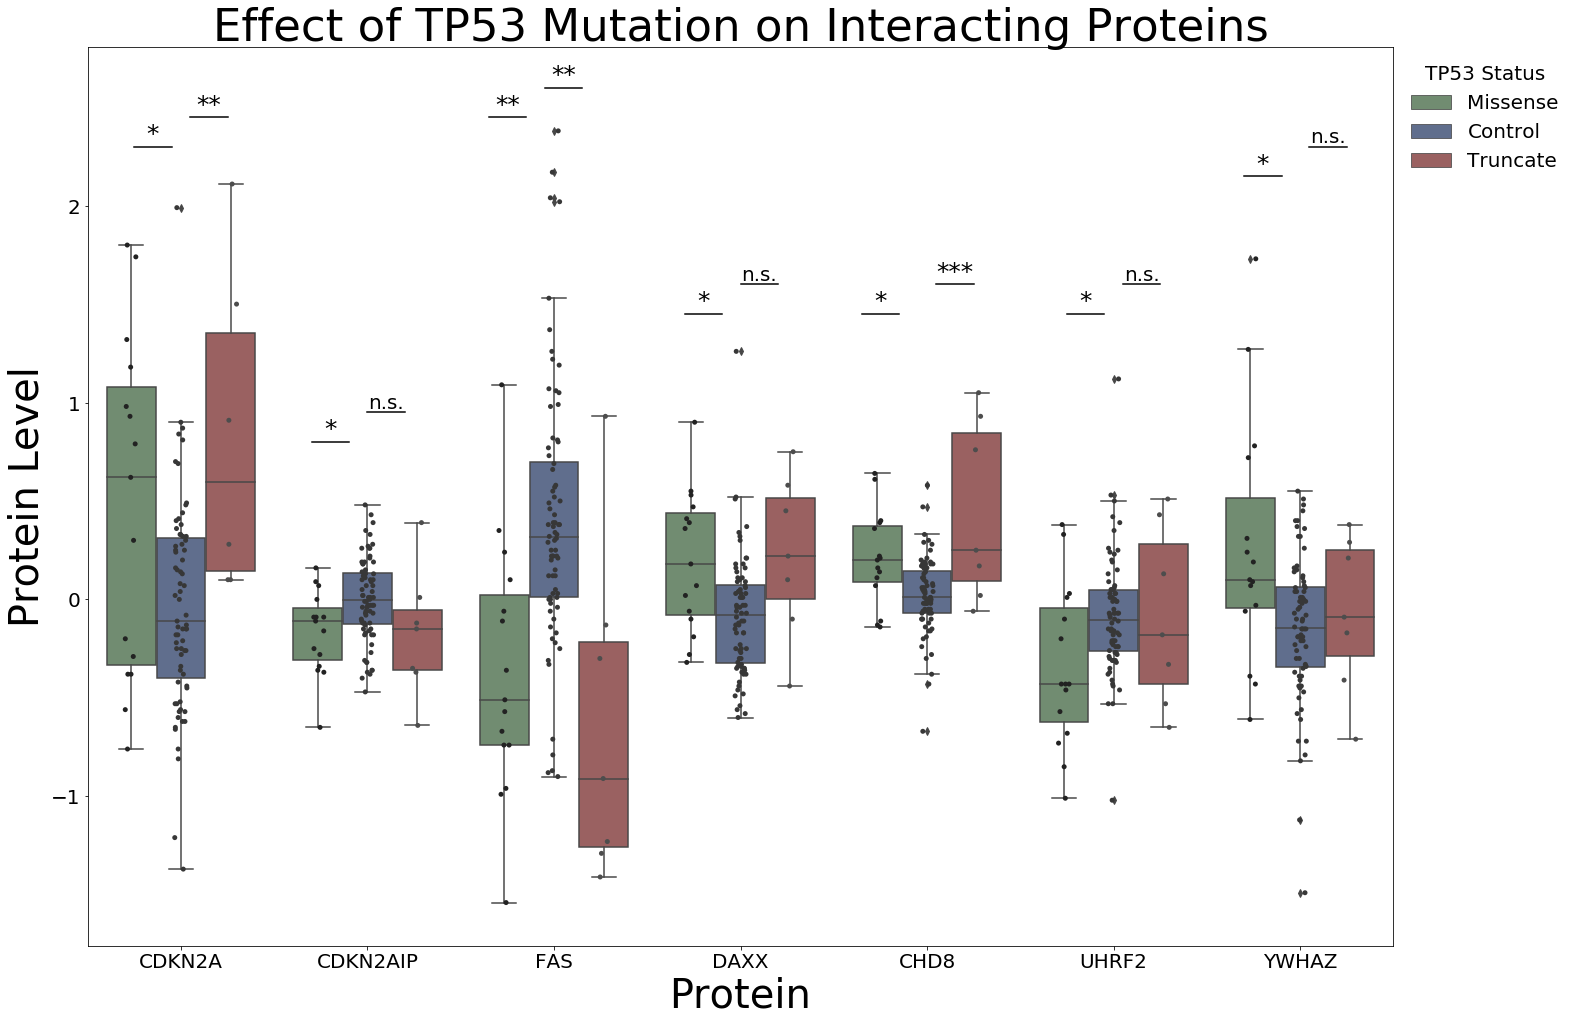

In [167]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Missense": "#6C906D", "Control": "#596B94", "Truncating": "#A35857"}

#Create the plot
boxplt = sns.boxplot(data=plotdf, x='Protein', y='Proteomics', hue='Mutation', palette=my_pal).set_title("Effect of TP53 Mutation on Interacting Proteins", fontsize='45')
boxplt = sns.stripplot(data=plotdf, x='Protein', y='Proteomics', hue='Mutation', dodge=True, color='.3')

#Add styling
boxplt.set_xlabel('Protein', fontsize='40')
boxplt.set_ylabel('Protein Level', fontsize='40')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:3], ['Missense', 'Control', 'Truncate'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))

#Add significance indicator: CDKN2A/Missense
x1, x2 = -0.25, -0.05
y, h, col = 2, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize='25')

#Add significance indicator: CDKN2A/Truncating
x1, x2 = 0.05, 0.25
y, h, col = 2.15, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize='25')

#Add significance indicator: CDKN2AIP/Missense
x1, x2 = 0.7, 0.9
y, h, col = 0.5, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize='25')

#Add significance indicator: CDKN2AIP/Truncating
x1, x2 = 1, 1.2
y, h, col = 0.65, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "n.s.", ha='center', va='bottom', color=col, fontsize='20')

#Add significance indicator: FAS/Missense
x1, x2 = 1.65, 1.85
y, h, col = 2.15, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize='25')

#Add significance indicator: FAS/Truncating
x1, x2 = 1.95, 2.15
y, h, col = 2.3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize='25')

#Add significance indicator: DAXX/Missense
x1, x2 = 2.7, 2.9
y, h, col = 1.15, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize='25')

#Add significance indicator: DAXX/Truncating
x1, x2 = 3, 3.2
y, h, col = 1.3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "n.s.", ha='center', va='bottom', color=col, fontsize='20')

#Add significance indicator: CHD8/Missense
x1, x2 = 3.65, 3.85
y, h, col = 1.15, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize='25')

#Add significance indicator: CHD8/Truncating
x1, x2 = 4.05, 4.25
y, h, col = 1.3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col, fontsize='25')

#Add significance indicator: UHRF2/Missense
x1, x2 = 4.75, 4.95
y, h, col = 1.15, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize='25')

#Add significance indicator: UHRF2/Truncating
x1, x2 = 5.05, 5.25
y, h, col = 1.3, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "n.s.", ha='center', va='bottom', color=col, fontsize='20')

#Add significance indicator: YWHAZ/Missense
x1, x2 = 5.7, 5.9
y, h, col = 1.85, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize='25')

#Add significance indicator: YWHAZ/Truncating
x1, x2 = 6.05, 6.25
y, h, col = 2, .3, 'k'
plt.plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "n.s.", ha='center', va='bottom', color=col, fontsize='20')

fig = boxplt.get_figure()
fig.savefig('p53_interacting_poster.png', dpi=300)
plt.show()

## TP53 Mutational Effects on p53

<b>Build dataframe for plotting</b>

In [129]:
proteomicsdf = CPTAC.compare_mutations(proteomics, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][['Mutation', gene]]

In [130]:
phosdf = CPTAC.compare_mutations(phos, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'][['TP53-S315']]

In [131]:
plotdf = proteomicsdf.join(phosdf)
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Truncating',
                                      'Frame_Shift_Ins': 'Truncating',
                                      'Nonsense_Mutation': 'Truncating',
                                      'Wildtype': 'Control',
                                      'Missense_Mutation': 'Missense'}})
plotdf = pd.melt(plotdf, id_vars=['Mutation'], value_vars=['TP53', 'TP53-S315'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Missense") | (plotdf["Mutation"] == "Truncating")]
plotdf = plotdf.dropna(axis=0)

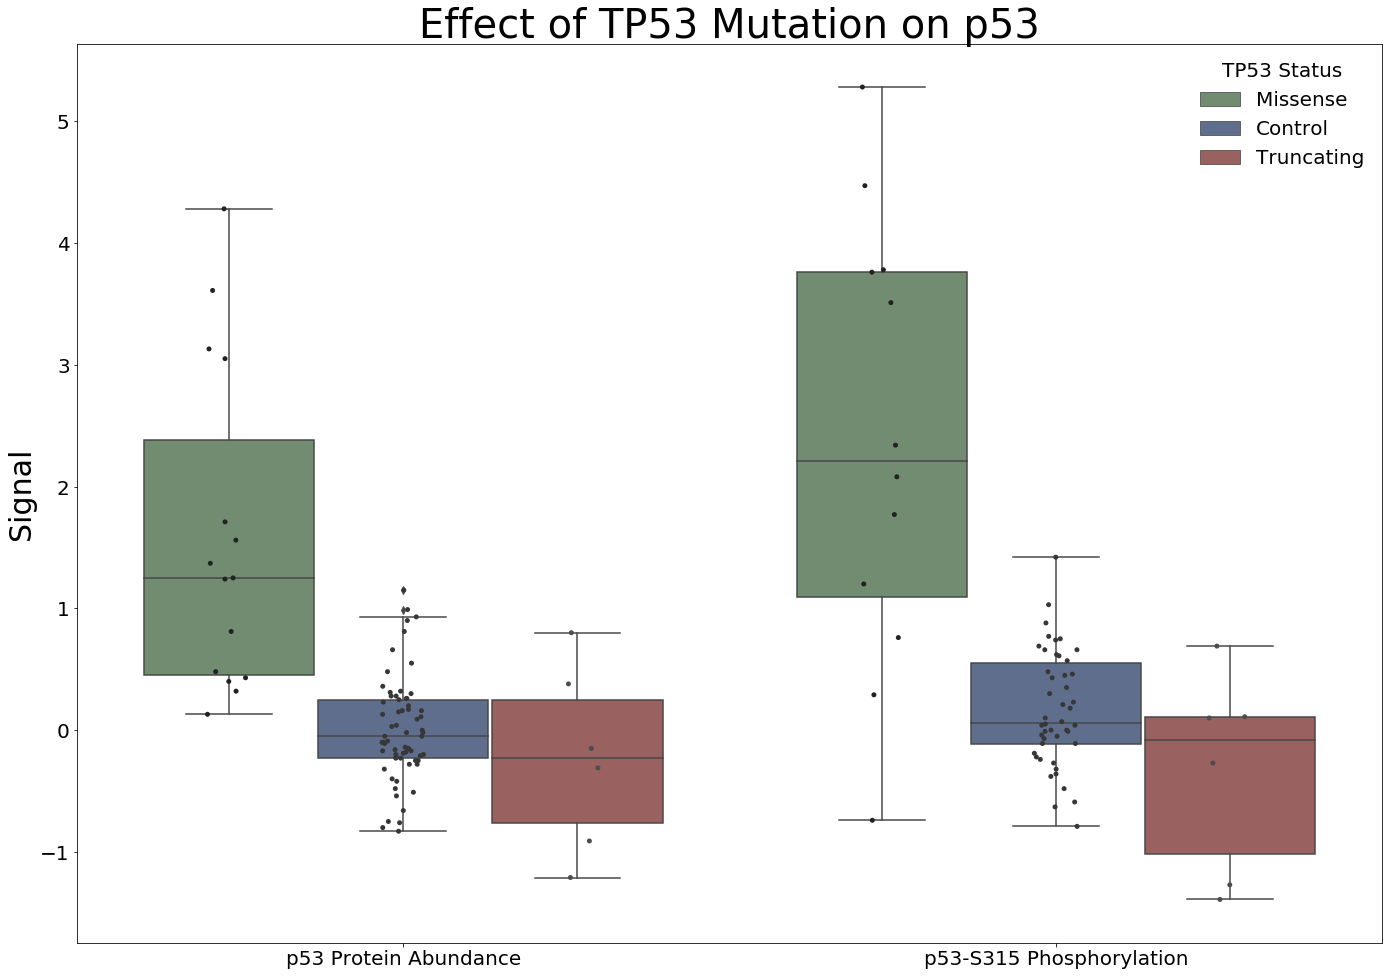

In [133]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Missense": "#6C906D", "Control": "#596B94", "Truncating": "#A35857"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_title("Effect of TP53 Mutation on p53", fontsize='40')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.set_xticklabels(['p53 Protein Abundance', 'p53-S315 Phosphorylation'])
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:3], ['Missense', 'Control', 'Truncating'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('p53_cis.png', dpi=300)
plt.show()

## TP53 and CABLES1

### Retrieve the data (only significant phosphorylation sites as determined by previous tests are included)

In [161]:
protein = 'CABLES1'
proteomicsdf = CPTAC.compare_mutations(proteomics, protein, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][[protein]]

In [162]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1).drop('CABLES1-S291', axis=1)

### Control/Truncating/Missense Plot

In [163]:
plotdf = proteomicsdf.join(phosdf)
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Truncating',
                                      'Frame_Shift_Ins': 'Truncating',
                                      'Nonsense_Mutation': 'Truncating',
                                      'Wildtype': 'Control',
                                      'Missense_Mutation': 'Missense'}})
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Missense") | (plotdf["Mutation"] == "Truncating")]
plotdf = plotdf.dropna(axis=0)

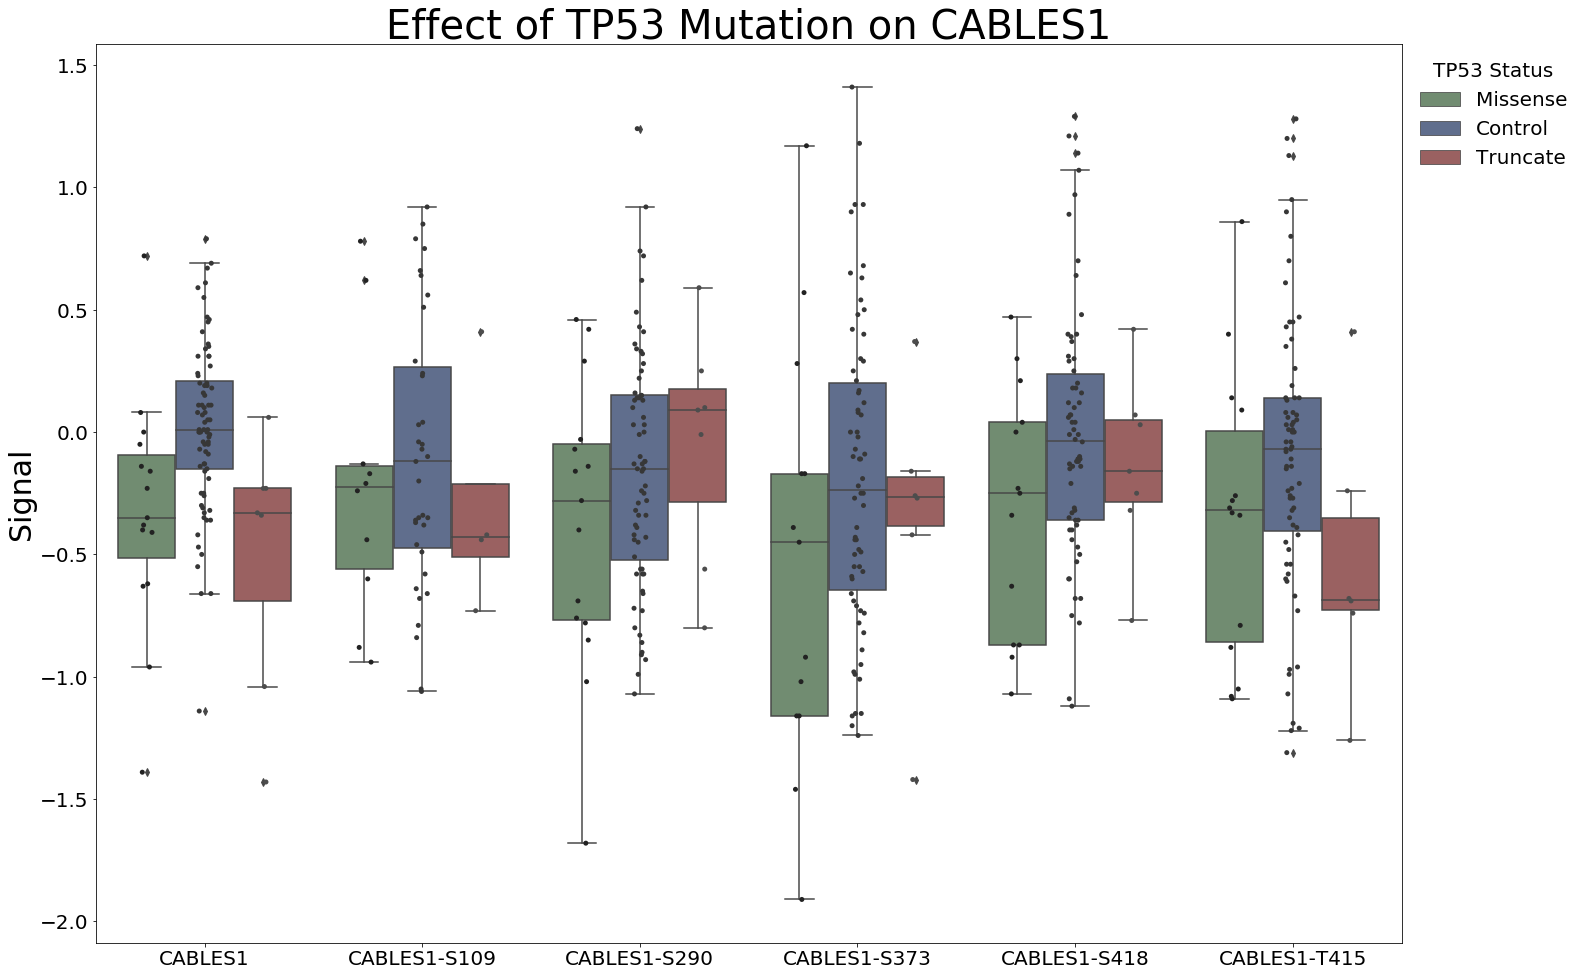

In [164]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Missense": "#6C906D", "Control": "#596B94", "Truncating": "#A35857"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.set_title("Effect of TP53 Mutation on CABLES1", fontsize='40')
#boxplt.set_xticklabels(['p53 Protein Abundance', 'p53-S315 Phosphorylation'])
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:3], ['Missense', 'Control', 'Truncate'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))

fig = boxplt.get_figure()
fig.savefig('p53_cables1.png', dpi=300)
plt.show()

## TP53 and AURKA

In [150]:
protein = 'AURKA'
proteomicsdf = CPTAC.compare_mutations(proteomics, protein, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][[protein, 'Mutation']]

In [151]:
plotdf = proteomicsdf
plotdf['Type'] = 'AURKA'
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Truncating',
                                      'Frame_Shift_Ins': 'Truncating',
                                      'Nonsense_Mutation': 'Truncating',
                                      'Wildtype': 'Control',
                                      'Missense_Mutation': 'Missense'}})
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Missense") | (plotdf["Mutation"] == "Truncating")]
plotdf = plotdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=True)

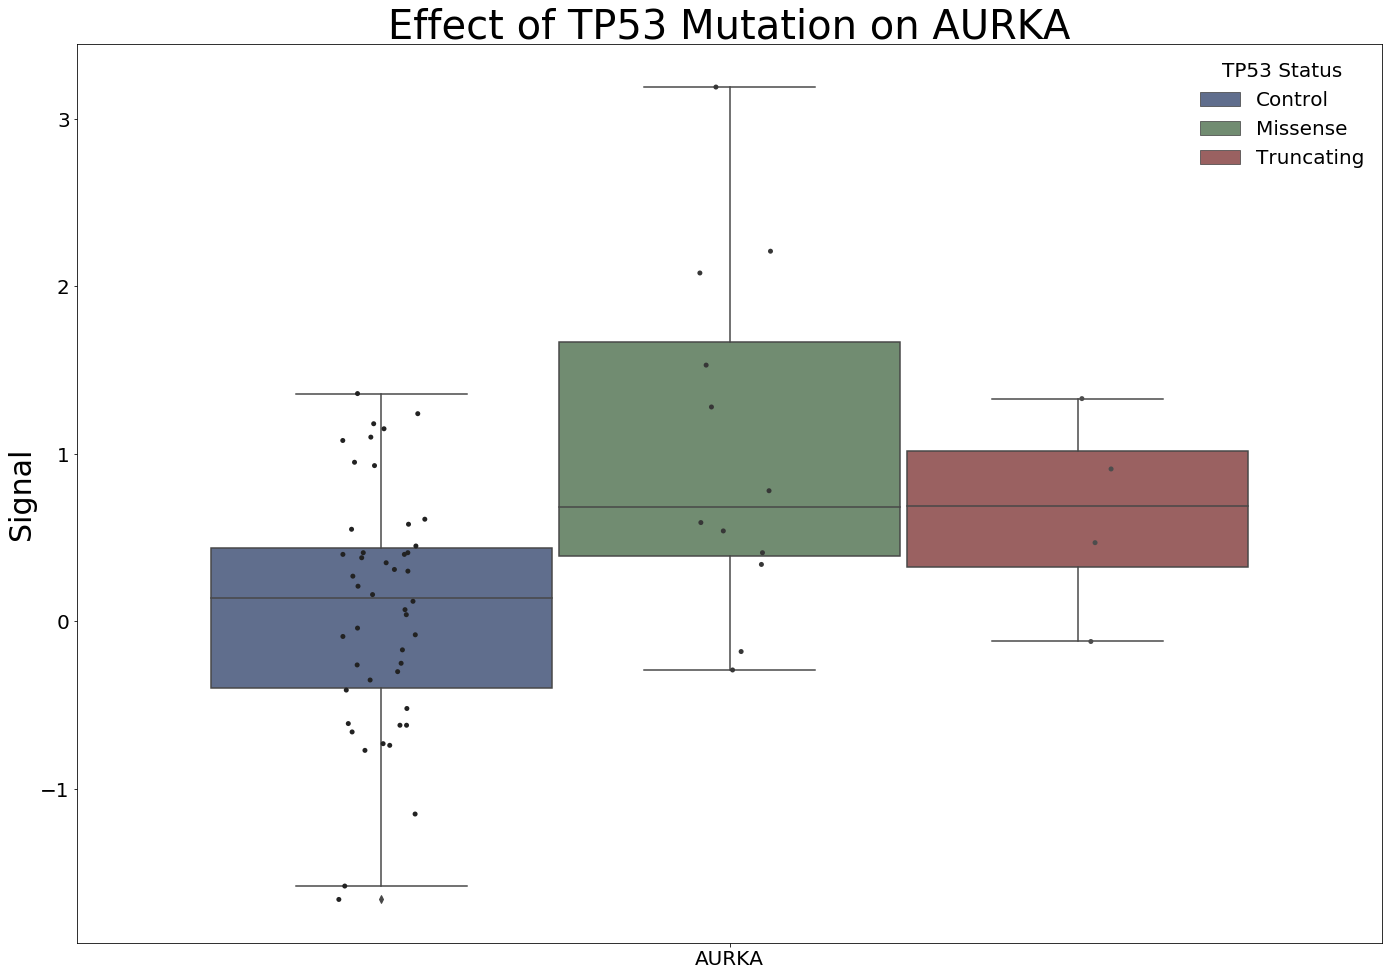

In [152]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Missense": "#6C906D", "Control": "#596B94", "Truncating": "#A35857"}

#Create the plot
boxplt = sns.boxplot(x='Type', y=protein, hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y=protein, hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.set_title("Effect of TP53 Mutation on AURKA", fontsize='40')
#boxplt.set_xticklabels(['p53 Protein Abundance', 'p53-S315 Phosphorylation'])
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:3], ['Control', 'Missense', 'Truncating'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))

fig = boxplt.get_figure()
fig.savefig('p53_aurka.png', dpi=300)
plt.show()

## TP53 and HSP90AB1

In [145]:
protein = 'HSP90AB1'
proteomicsdf = CPTAC.compare_mutations(proteomics, protein, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][[protein]]

In [146]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [147]:
plotdf = proteomicsdf.join(phosdf)
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Truncating',
                                      'Frame_Shift_Ins': 'Truncating',
                                      'Nonsense_Mutation': 'Truncating',
                                      'Wildtype': 'Control',
                                      'Missense_Mutation': 'Missense'}})
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Missense") | (plotdf["Mutation"] == "Truncating")]
plotdf = plotdf.dropna(axis=0)

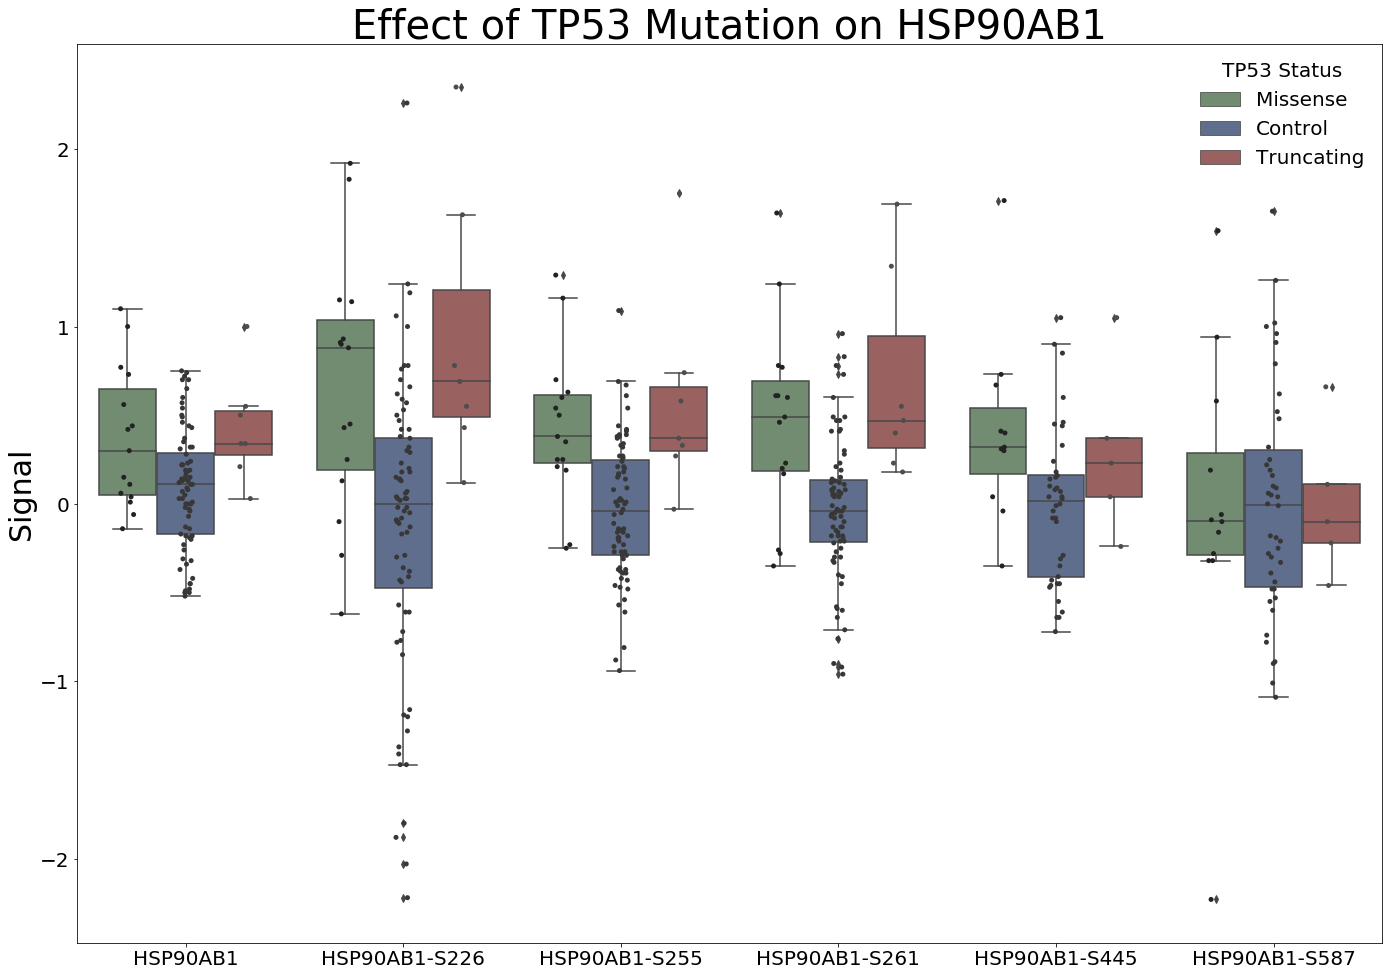

In [149]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Missense": "#6C906D", "Control": "#596B94", "Truncating": "#A35857"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.set_title("Effect of TP53 Mutation on HSP90AB1", fontsize='40')
#boxplt.set_xticklabels(['p53 Protein Abundance', 'p53-S315 Phosphorylation'])
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:3], ['Missense', 'Control', 'Truncating'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))

fig = boxplt.get_figure()
fig.savefig('p53_hsp90.png', dpi=300)
plt.show()